We will denoise images in the CIFAR-100 dataset and reduce the dimension to 2D by an AutoEncoder Model. Lets explore the dataset:

* This dataset has 100 classes containing 600 images each. 
* There are 500 training images and 100 testing images per class. 
* The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

Lets start by importing some libraries which are necessary for the problem

In [ ]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar100

from keras.utils.np_utils import to_categorical
from keras import backend as K

from sklearn.manifold import TSNE

import keras 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")

# Loading and Preprocessing the Dataset

We need to import cifar100 dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("")
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

169017344/169001437 [==============================] - 7s 0us/step
X_train.shape: (50000, 32, 32, 3)
X_test.shape: (10000, 32, 32, 3)

y_train.shape: (50000, 1)
y_test.shape: (10000, 1)


We have imported the dataset as train and test datasets.
>
***Train Dataset*** which will be used during model training has 50000 images with 32 widths and 32 heigths. The images has 3 channel because of coloured.
   * X_train: pixel values of the images,
   * y_train: labels of the images.

>
***Test Dataset*** which we will test our model's performance has 10000 images.
   * X_test: pixel values of the images,
   * y_test: labels of the images

>Lets assign this values to variables;

In [ ]:
nb_samples = X_train.shape[0]
imgs_width = X_train.shape[1]
imgs_height = X_train.shape[2]
nb_channels = X_train.shape[3]

The train and test datasets should be transformed in preprocessing process. What we will do is;
* X_train and X_test datasets need to be reshaped according to their format and their values should be normalized from 0 to 1 to make model work better.

In [ ]:
def reshape_normalize(data):

  if K.image_data_format() == "channels_last":
    data = data.reshape(-1, imgs_width, imgs_height, nb_channels).astype("float64") / 255.

  else:
    data = data.reshape(-1, nb_channels, imgs_width, imgs_height).astype("float64") / 255.

  return data

X_train = reshape_normalize(X_train)
X_test = reshape_normalize(X_test)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (50000, 32, 32, 3)
X_test.shape: (10000, 32, 32, 3)


X_train and X_test datasets have been normalized. However, their shapes have not changed because the shapes are already formatted. The reason we typed the reshape code is that there may be some datasets which comes new later and should be reshaped according to its format.

Lets see first 9 images from X_train by using a for loop.

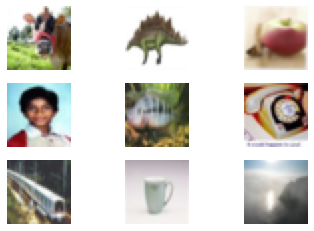

In [ ]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(X_train[i])
  plt.axis("off")
plt.show()

We have finished the preprocessing for all the datasets. Lets get to build an AutoEncoder Model for our problem.

# Building a Model

An AutoEncoder Model consists of three components:

* Encoder: An encoder takes an input and maps it to a latent space, and encodes the input image as a compressed representation in a reduced dimension. The compressed image is the distorted version of the original image.
The predict function works with the encoder components.
* Code: This part of the network contains the reduced representation of the input that is fed into the decoder.
* Decoder: An decoder takes that latent space and maps it to an output. This network is responsible for reconstructing the input back to the original dimensions from the code.

>

Lets start to building an encoder model and an decoder model to build an AutoEncoder Model.

In [ ]:
class AutoEncoder(keras.Model):

  def __init__(self, **kwargs):
    super().__init__()

  def encoder(self):

    input_ =  Input(shape = X_train.shape[1:]) # 32x32x3

    cnn_layer1 = Conv2D(16, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(input_) #32x32x16
    cnn_layer1 = BatchNormalization()(cnn_layer1)
    cnn_layer1 = Activation("selu")(cnn_layer1)
    cnn_layer1 = MaxPooling2D(2)(cnn_layer1) #16x16x16

    cnn_layer2 = Conv2D(32, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(cnn_layer1) #16x16x32
    cnn_layer2 = BatchNormalization()(cnn_layer2)
    cnn_layer2 = Activation("selu")(cnn_layer2)
    cnn_layer2 = MaxPooling2D(2)(cnn_layer2) #8x8x32

    cnn_layer3 = Conv2D(64, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(cnn_layer2) #8x8x64
    cnn_layer3 = BatchNormalization()(cnn_layer3)
    cnn_layer3 = Activation("selu")(cnn_layer3)

    cnn_layer4 = Conv2D(64, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(cnn_layer3) #8x8x64
    cnn_layer4 = BatchNormalization()(cnn_layer4)
    cnn_layer4 = Activation("selu")(cnn_layer4)
    cnn_layer4 = MaxPooling2D(2)(cnn_layer4) #4x4x64

    cnn_layer5 = Conv2D(128, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(cnn_layer4) #4x4x128
    cnn_layer5 = BatchNormalization()(cnn_layer5)
    cnn_layer5 = Activation("selu")(cnn_layer5)

    cnn_layer6 = Conv2D(128, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(cnn_layer5) #4x4x128
    cnn_layer6 = BatchNormalization()(cnn_layer6)
    cnn_layer6 = Activation("selu")(cnn_layer6)
    cnn_layer6 = MaxPooling2D(2)(cnn_layer6) #2x2x128

    cnn_layer7 = Conv2D(256, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(cnn_layer6) #2x2x256
    cnn_layer7 = BatchNormalization()(cnn_layer7)
    cnn_layer7 = Activation("selu")(cnn_layer7)

    cnn_layer8 = Conv2D(256, kernel_size=3, kernel_initializer="lecun_normal", padding="same")(cnn_layer7) #2x2x256
    cnn_layer8 = BatchNormalization()(cnn_layer8)
    cnn_layer8 = Activation("selu")(cnn_layer8)
    cnn_layer8 = MaxPooling2D(2)(cnn_layer8)  #1x1x256

    encoder = Model(inputs = [input_], outputs = [cnn_layer8], name="encoder")

    return encoder

  def decoder(self):
    
    input_ =  Input(shape = [1,1,256]) # 1x1x256

    conv_transpose_1 = Conv2DTranspose(256, kernel_size=3, strides=1, kernel_initializer="lecun_normal", padding="same")(input_) #2x2x128
    conv_transpose_1 = BatchNormalization()(conv_transpose_1)
    conv_transpose_1 = Activation("selu")(conv_transpose_1)

    conv_transpose_2 = Conv2DTranspose(128, kernel_size=3, strides=2, kernel_initializer="lecun_normal", padding="same")(conv_transpose_1) #4x4x64
    conv_transpose_2 = BatchNormalization()(conv_transpose_2)
    conv_transpose_2 = Activation("selu")(conv_transpose_2)

    conv_transpose_3 = Conv2DTranspose(128, kernel_size=3, strides=1, kernel_initializer="lecun_normal", padding="same")(conv_transpose_2) #8x8x32
    conv_transpose_3 = BatchNormalization()(conv_transpose_3)
    conv_transpose_3 = Activation("selu")(conv_transpose_3)

    conv_transpose_4 = Conv2DTranspose(64, kernel_size=3, strides=2, kernel_initializer="lecun_normal", padding="same")(conv_transpose_3) #16x16x32
    conv_transpose_4 = BatchNormalization()(conv_transpose_4)
    conv_transpose_4 = Activation("selu")(conv_transpose_4)

    conv_transpose_5 = Conv2DTranspose(64, kernel_size=3, strides=1, kernel_initializer="lecun_normal", padding="same")(conv_transpose_4) #16x16x32
    conv_transpose_5 = BatchNormalization()(conv_transpose_5)
    conv_transpose_5 = Activation("selu")(conv_transpose_5)

    conv_transpose_6 = Conv2DTranspose(32, kernel_size=3, strides=2, kernel_initializer="lecun_normal", padding="same")(conv_transpose_5) #16x16x32
    conv_transpose_6 = BatchNormalization()(conv_transpose_6)
    conv_transpose_6 = Activation("selu")(conv_transpose_6)

    conv_transpose_7 = Conv2DTranspose(16, kernel_size=3, strides=2, kernel_initializer="lecun_normal", padding="same")(conv_transpose_6) #16x16x32
    conv_transpose_7 = BatchNormalization()(conv_transpose_7)
    conv_transpose_7 = Activation("selu")(conv_transpose_7)

    output = Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid")(conv_transpose_7) #32x32x3

    decoder = Model(inputs = [input_], outputs = [output], name="decoder")
    
    return decoder

encoder = AutoEncoder().encoder()
decoder = AutoEncoder().decoder()

autoencoder = Sequential([encoder, decoder], name="AutoEncoder")

What we did? We created a class named as "AutoEncoder" which has "encoder" and "decoder" functions. The encoder function builds an Encoder Model with Functional API which compress images. The decoder function builds a Decoder Model with Functional API which transforms the image, coming from the Encoder Model, into its original dimension.

> Lets explain the functions detailed below:

***Encoder***: 
>
**Input layer** takes image as input (32,32,3)
>
**There are 8 Convolution layers**. All layers use 3x3 as kernel_size, "lecun_normal" as kernel_initializer and "same" method as padding. After each convolution layers, Batch Normalization to normalize image and "selu" activation function will be used.
> Some CNN layers use MaxPooling2D for downsampling, but some layers don't.
>
**Output layer** is the last convolution layer named as "cnn_layer8".
>
In the end of the function, we assigned an encoder variable to build an Encoder Model by taking the input and output layers

***Decoder***: 
>
**Input layer** takes the compresed image coming from Encoder as input (1,1,256).
>
**Transposed convolution layers** are used in all layers instead of Conv2D for upsampling according to the strides values in the layers. As we mentioned above, this is the main difference between Encoder and Decoder process, 
> **All the transposed convolution layers** use 3x3 as kernel_size, "lecun_normal" as kernel_initializer and "same" method as padding. After each layers, Batch Normalization to normalize image and "selu" activation function will be used.
>
**Output layer** is the last transposed convolution layer named as "output" which creates 3 feature maps which represent the channel and uses "sigmoid" as activation. The compressed image will be transformed it's initial shape: (32,32,3).
>
In the end of the function, we assigned an decoder variable to build a Decoder Model by taking the input and output layers.

Finally, we have built an AutoEncoder Model based on the Encoder and Decoder Models with Sequential API.

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 256)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1, 1, 256)        590080    
 nspose)                                                         
                                                                 
 batch_normalization_8 (Batc  (None, 1, 1, 256)        1024      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 2, 2, 128)        295040    
 ranspose)                                                       
                                                           

In [ ]:
autoencoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 1, 1, 256)         1170976   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         1169699   
                                                                 
Total params: 2,340,675
Trainable params: 2,337,411
Non-trainable params: 3,264
_________________________________________________________________


As we have seen, the AutoEncoder Model has totally 2.340.675 parameters. Only 3.264 parameters are not trainable.

# Compiling, Fitting and Evaluating the Model

In [ ]:
optimizer = RMSprop(learning_rate = 0.0001, momentum=0.5, rho=0.2)

autoencoder.compile(loss = "binary_crossentropy",
                    optimizer = optimizer,
                    metrics = ["accuracy"])

The AutoEncoder Model has been compiled with parameters below;
* "binary_crossentropy" as loss,
* RMSprop optimizer with the 0.0001 learning rate, 0.5 momentum value and 0.2 rho value,
* "accuracy" as evaluation metrics.

In [ ]:
checkpoint = ModelCheckpoint("cifar100_autoencoder.h5",
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               restore_best_weights=True)

history = autoencoder.fit(X_train, X_train, 
                          batch_size=64,
                          epochs=50,
                          validation_split=0.2,
                          callbacks=[checkpoint, early_stopping],
                          verbose=1)

Epoch 1/50
625/625 [==============================] - 15s 16ms/step - loss: 0.6106 - accuracy: 0.4935 - val_loss: 0.5808 - val_accuracy: 0.5704
Epoch 2/50
625/625 [==============================] - 7s 12ms/step - loss: 0.5787 - accuracy: 0.5928 - val_loss: 0.5706 - val_accuracy: 0.6178
Epoch 3/50
625/625 [==============================] - 8s 12ms/step - loss: 0.5724 - accuracy: 0.6131 - val_loss: 0.5663 - val_accuracy: 0.6216
Epoch 4/50
625/625 [==============================] - 9s 14ms/step - loss: 0.5689 - accuracy: 0.6229 - val_loss: 0.5638 - val_accuracy: 0.6291
Epoch 5/50
625/625 [==============================] - 8s 12ms/step - loss: 0.5666 - accuracy: 0.6319 - val_loss: 0.5617 - val_accuracy: 0.6387
Epoch 6/50
625/625 [==============================] - 7s 12ms/step - loss: 0.5647 - accuracy: 0.6361 - val_loss: 0.5595 - val_accuracy: 0.6434
Epoch 7/50
625/625 [==============================] - 7s 12ms/step - loss: 0.5632 - accuracy: 0.6525 - val_loss: 0.5580 - val_accuracy: 0.668

The AutoEncoder Model:
* has been trained on the X_train datasets with 50 epochs using 64 samples in every training iteration. 
* has been validated with %20 of the X_train dataset.
* has used ModelCheckpoint, saving and loading the best weights for the model, and EarlyStopping stopping the training if no more improvement and loading the best weights for the model.

> 
After the training, we can see how the model's performance in each epoch. The training iteration has been stopped when 20th epoch finished because of no more improvement. 

>
According to the training result, the AutoEncoder model has above %70 training and validation scores and averagely 0.55 loss. We may increase the performance by arranging the parameters of the Encoder and Decoder layers, or recompile the model with new values. You can try if you want...

Now, lets see the training process on a figure;

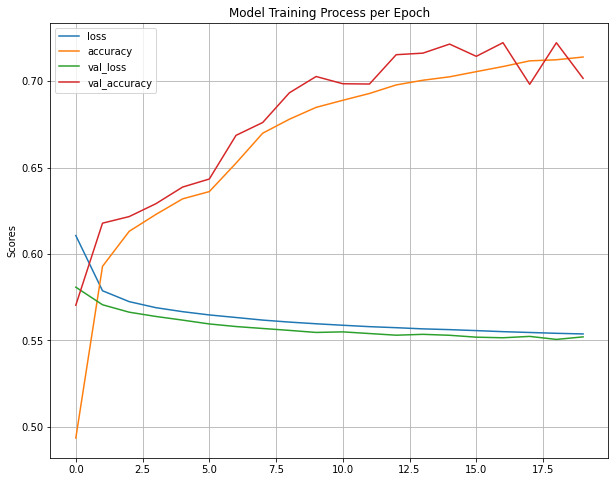

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.title("Model Training Process per Epoch")
plt.ylabel("Epochs")
plt.ylabel("Scores")
plt.grid(True)
plt.show()

Lets evaluate the model on the test dataset.

In [ ]:
loss, accuracy = autoencoder.evaluate(X_test, X_test, batch_size=64)
print("Loss:", loss)
print("Accuracy:", accuracy)

157/157 [==============================] - 2s 7ms/step - loss: 0.5517 - accuracy: 0.7208
Loss: 0.551672101020813
Accuracy: 0.720815896987915


Our model has been tested on the X_test dataset with 0.55 loss and %72 accuracy score. Thats not a bad result as much as denigrating, but not so perfect as much as praising. We, however, have an evaluation result enough to go on.

In [ ]:
autoencoder.save("cifar100_autoencoder.h5")

Saved the model as "cifar100_autoencoder" in h5 format.

In [ ]:
autoencoder = load_model("cifar100_autoencoder.h5")

Loaded the model with the name saved

Lets compare 5 images, which will be predicted by the model, with the real images.

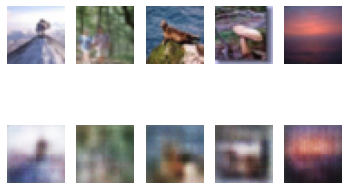

In [ ]:
def comparing_imgs(data, samples):

  ae_pred = autoencoder.predict(data)
  
  for i in range(samples):
    
    #real images
    plt.subplot(2, samples, i+1)
    plt.imshow(data[i])
    plt.axis("off")

    #denoised images
    plt.subplot(2, samples, samples + i + 1)
    plt.imshow(ae_pred[i])
    plt.axis("off")
  plt.show()

comparing_imgs(X_test, 5)

The predicted images are a bit blurry.

# Reducing the Dimension To 2D

We have denoised the images with averagely %72 rate. It's now time to reduce the dimensions of the images in the dataset to 2D. In this process, we will use only Encoder Model on the X_test dataset, instead of AutoEncoder Model.

In [ ]:
encoder_pred = encoder.predict(X_test)

encoder_samples, encoder_rows, encoder_cols, encoder_channels = encoder_pred.shape

X_test_reduced = encoder_pred.reshape(encoder_samples, encoder_rows*encoder_cols*encoder_channels) #We should reshape the data which has been predicted by Encoder Model as (10000, 1*1*256)

Now, TSNE model, which is a tool to visualize high-dimensional data, will be used in this last process to visualize the X_test dataset as 2D.

In [ ]:
tsne = TSNE(n_components = 2)

data_to_2D = tsne.fit_transform(X_test_reduced)

The dimensions of the images have been reduced to 2D. Lets now see on a scatterplot.

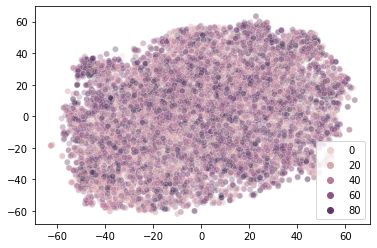

In [ ]:
sns.scatterplot(data_to_2D[:, 0], data_to_2D[:, 1], hue = y_test[:,0], alpha=0.3);

It's done...